# Preparation

In [3]:
# %load_ext ipycache
import iminuit
# %load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
results = pd.DataFrame()

In [5]:
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"\u03C1 = {r:.2f}\np = {p:.2f}", #unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)

# Load C14 models

In [24]:
import c14_models

# Read patient data

In [135]:
data = pd.read_csv('../data/C14data_liver_samples_20200227.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
# data = data.query('pathology not in ["Y", "C"]')
exp_data = data

In [136]:
exp_data.head()

,type,sample,ploidy,pathology,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age,age
0,hepatocyte,HL#11,2n,T,1975.333333,2019.750000,0.01620,0.00640,77.0,44.416667,44.416667
1,hepatocyte,HL#11,4n,T,1975.333333,2019.750000,0.03960,0.00685,12.0,44.416667,44.416667
2,hepatocyte,HL#12,2n4n,T,1947.833333,2017.916667,0.02460,0.00660,59.0,70.083333,70.083333
3,hepatocyte,HL#14,2n4n,T,1943.000000,2018.000000,0.07402,0.01163,54.0,75.000000,75.000000
4,hepatocyte,HL#3,2n4n,C,1951.333333,2017.333333,0.02280,0.00445,96.0,66.000000,66.000000


In [137]:
exp_data.describe()

,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age,age
count,104.000000,104.000000,104.000000,104.000000,71.000000,104.000000,104.000000
mean,1961.767628,2015.822115,0.046423,0.007360,61.345070,54.054487,54.054487
std,18.059012,3.568581,0.027584,0.003522,29.050644,18.107601,18.107601
min,1932.583333,2004.833333,0.003700,0.002300,12.000000,20.000000,20.000000
25%,1946.500000,2016.500000,0.026300,0.004740,40.000000,37.833333,37.833333
50%,1960.416667,2017.208333,0.041250,0.006500,61.000000,57.166667,57.166667
75%,1975.333333,2017.500000,0.067134,0.009075,72.000000,66.000000,66.000000
max,1997.333333,2019.750000,0.131107,0.021571,135.000000,84.666667,84.666667


# Plot data 

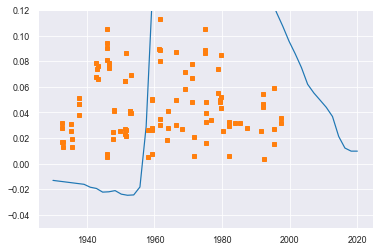

In [138]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 's')
plt.ylim(-0.05, 0.12)
plt.show()

# Individual rates

In [139]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    """ For very high turnover rates return the atmospheric C14 concentration
        at the date of collection to avoid lengthy computations.
    """
    if loglam <= 10:
        lam = np.exp(loglam)
        return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]
    else:
        return c14_models.C_atm(Dcoll)

def diffI1(loglam, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    loglam)
    diff = (model_data - data['d14C'])
    return diff

def SSE_individual(p, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    p)
    sse = np.sum((model_data - data['d14C'])**2)
    return sse    

def plot_diffI1(loglammin, loglammax, data):
    loglams = np.linspace(loglammin, loglammax)
    diff = np.vectorize(diffI1, excluded=[1])(loglams, data)
    plt.title(data['code'])
    plt.plot(loglams, diff, label='Diff predicted to measured')
    plt.plot([loglammin, loglammax], [0, 0], color='black')

def individual_rate(i, loglam0=np.log(0.1)):
    try:
#         return np.exp(sp.optimize.brentq(diffI1, -8, 10, args=exp_data.iloc[i]))
        return np.exp(sp.optimize.newton(diffI1, loglam0, args=([exp_data.iloc[i]])))
    except:
        return np.nan
    
def individual_rate_SSE(i, loglam0=np.log(0.1)):
    r = np.exp(
            sp.optimize.minimize(
                SSE_individual, loglam0, args=(exp_data.iloc[i]), method='Nelder-Mead'
            )['x'][0]
        )
    return r

In [140]:
p=multiprocessing.Pool(processes=7)

In [141]:
exp_data['individual_rate_SSE'] = p.map(individual_rate_SSE, range(len(exp_data)))

In [142]:
exp_data['individual_rate_newton'] = p.map(individual_rate, range(len(exp_data)))

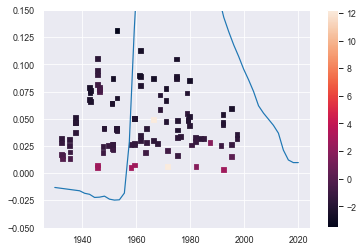

In [143]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.scatter(exp_data['Dbirth'], exp_data['d14C'], marker='s', c=np.log(exp_data['individual_rate_SSE']))
plt.colorbar()
plt.ylim(-0.05, 0.15)
plt.show()

# Compare to graphical solution

In [144]:
# %%cache -d ipycache graphical.pkl
# fig, axs = plt.subplots(int(np.ceil(len(exp_data)/8)), 8, sharex=True, sharey=True, figsize=(8.3, 11.7))

# for ax in axs[-1]:
#     ax.set_xlabel(u'λ')
# for ax in axs[:,0]:
#     ax.set_ylabel(u'ΔC14')
    
# axs = axs.flatten()
# loglammin, loglammax = -10, 5
# loglams = np.linspace(loglammin, loglammax)
# for (i, data), ax in zip(exp_data.iterrows(), axs):
#     diff = np.vectorize(diffI1, excluded=[1])(loglams, data)
#     ax.set_title(data['code'])
#     ax.plot(loglams, diff, label='Diff predicted to measured')
#     ax.axhline(0, color='black')
#     ax.axvline(np.log(data['individual_rate_SSE']), color='black')
    
# ax.set_xlim(loglammin, loglammax)
# ax.set_ylim(-0.07, 0.07)
# plt.tight_layout()
# plt.savefig('../../results/plots/individual_rate_solution.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# Plot rates

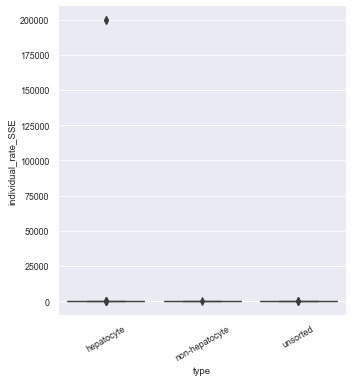

In [145]:
ax = sns.catplot(data=exp_data, x='type', y='individual_rate_SSE', kind='box')
ax.set_xticklabels(rotation=30)
plt.show()

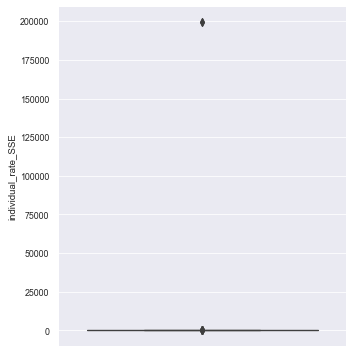

In [146]:
ax = sns.catplot(data=exp_data,  y='individual_rate_SSE', kind='box')
plt.show()

# Detect outliers based on IQR

In [147]:
# Computing IQR
Q1 = exp_data['individual_rate_SSE'].quantile(0.25)
Q3 = exp_data['individual_rate_SSE'].quantile(0.75)
IQR = Q3 - Q1

# Selecting Values between Q1-1.5IQR and Q3+1.5IQR
exp_data['rate_is_not_outlier'] = exp_data.eval('(@Q1 - 1.5 * @IQR) <= individual_rate_SSE <= (@Q3 + 1.5 * @IQR)')

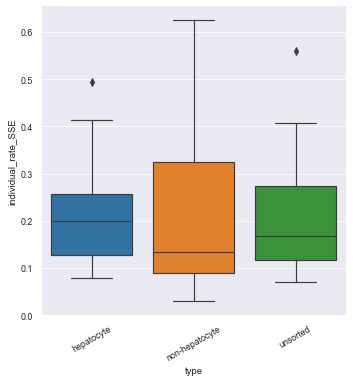

In [148]:
ax = sns.catplot(data=exp_data.query('rate_is_not_outlier'), x='type', y='individual_rate_SSE', kind='box')
# sns.swarmplot(data=exp_data, x='type', y='individual_rate_SSE', color='black', size=2)
ax.set_xticklabels(rotation=30)
plt.show()

# Sanity check of the results by comparing the two methods:

In [149]:
exp_data.query('rate_is_not_outlier').query('(individual_rate_SSE - individual_rate_newton)**2 > (1e-3)**2')

,type,sample,ploidy,pathology,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age,age,individual_rate_SSE,individual_rate_newton,rate_is_not_outlier


# Analysing results

I use the values obtained with SSE

In [150]:
exp_data['cell_age'] = 1. / exp_data['individual_rate_SSE']

In [151]:
exp_data.head()

,type,sample,ploidy,pathology,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age,age,individual_rate_SSE,individual_rate_newton,rate_is_not_outlier,cell_age
0,hepatocyte,HL#11,2n,T,1975.333333,2019.750000,0.01620,0.00640,77.0,44.416667,44.416667,0.323346,0.323352,True,3.092659
1,hepatocyte,HL#11,4n,T,1975.333333,2019.750000,0.03960,0.00685,12.0,44.416667,44.416667,0.126524,0.126526,True,7.903640
2,hepatocyte,HL#12,2n4n,T,1947.833333,2017.916667,0.02460,0.00660,59.0,70.083333,70.083333,0.267738,0.267745,True,3.734995
3,hepatocyte,HL#14,2n4n,T,1943.000000,2018.000000,0.07402,0.01163,54.0,75.000000,75.000000,0.082038,0.082040,True,12.189512
4,hepatocyte,HL#3,2n4n,C,1951.333333,2017.333333,0.02280,0.00445,96.0,66.000000,66.000000,0.348155,0.348157,True,2.872285


In [152]:
# exp_data = exp_data[exp_data['ploidy'] == '4n'].query('pathology in ["N", "T"]')

In [153]:
# exp_data

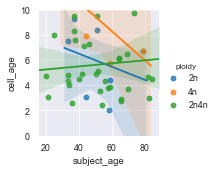

In [154]:
sns.pairplot(exp_data.query('rate_is_not_outlier').query('type == "hepatocyte"'),
            x_vars = ['subject_age'],
            y_vars = ['cell_age'],
             kind='reg',
            hue = 'ploidy')
plt.ylim(0, 10)
plt.show()

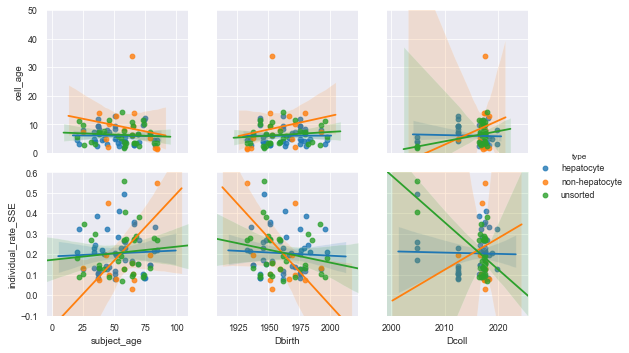

In [155]:
g = sns.pairplot(exp_data.query('rate_is_not_outlier'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age', 'individual_rate_SSE'],
             kind='reg',
            hue = 'type')
g.axes[0][0].set_ylim(0, 50)
g.axes[1][0].set_ylim(-0.1, 0.6)
plt.show()

# Plot for Olaf

## Rate

In [156]:
plot_data = exp_data.query('rate_is_not_outlier').query('type in ["hepatocyte", "non-hepatocyte", "unsorted"]')

In [157]:
plot_data['type'] = pd.Categorical(plot_data['type'])

In [158]:
plot_data['type'].cat.remove_unused_categories(inplace=True)

In [159]:
sns.set_context('paper')

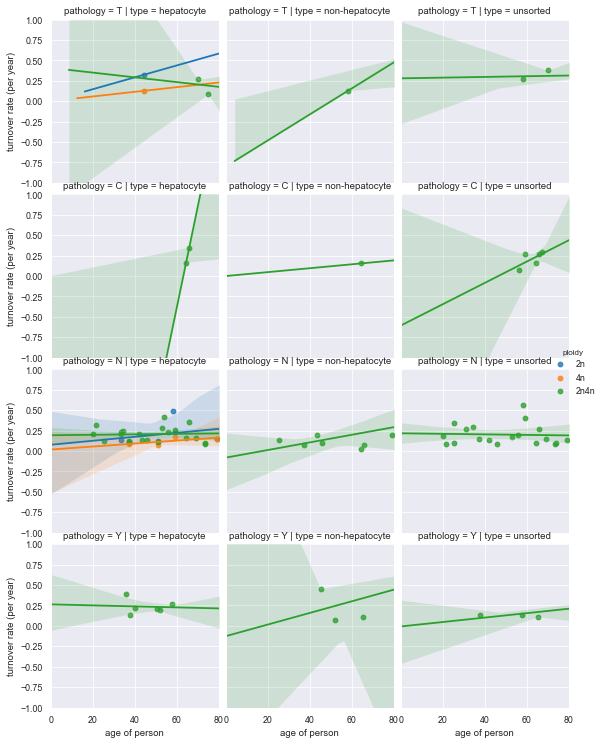

In [174]:
ax = sns.lmplot(x='subject_age', y='individual_rate_SSE', col='type', data=plot_data,
                col_order=['hepatocyte', 'non-hepatocyte', 'unsorted'], hue='ploidy',
               row='pathology')
ax.set_axis_labels(x_var='age of person', y_var='turnover rate (per year)')
ax.set(xlim=(0, 80), ylim=(-1, 1))
ax.fig.set_figwidth(8)
ax.fig.set_figheight(10)
# plt.savefig('../../results/plots/individual_rate_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

No significant correlation in the above data:

In [126]:
plot_data.groupby('type').apply(lambda g: pd.Series({key: value for key, value in zip(['r', 'p'],
    sp.stats.pearsonr(g['subject_age'], g['individual_rate_SSE']))}))

,r,p
type,,
hepatocyte,0.057026,0.737443
non-hepatocyte,0.513632,0.157249
unsorted,0.073003,0.746803


In [127]:
plot_data.groupby('type').apply(lambda g: smf.ols('individual_rate_SSE ~ subject_age', data=g).fit().params)

,Intercept,subject_age
type,,
hepatocyte,0.179437,0.000325
non-hepatocyte,-0.063764,0.004052
unsorted,0.190910,0.000470


## Cell Age

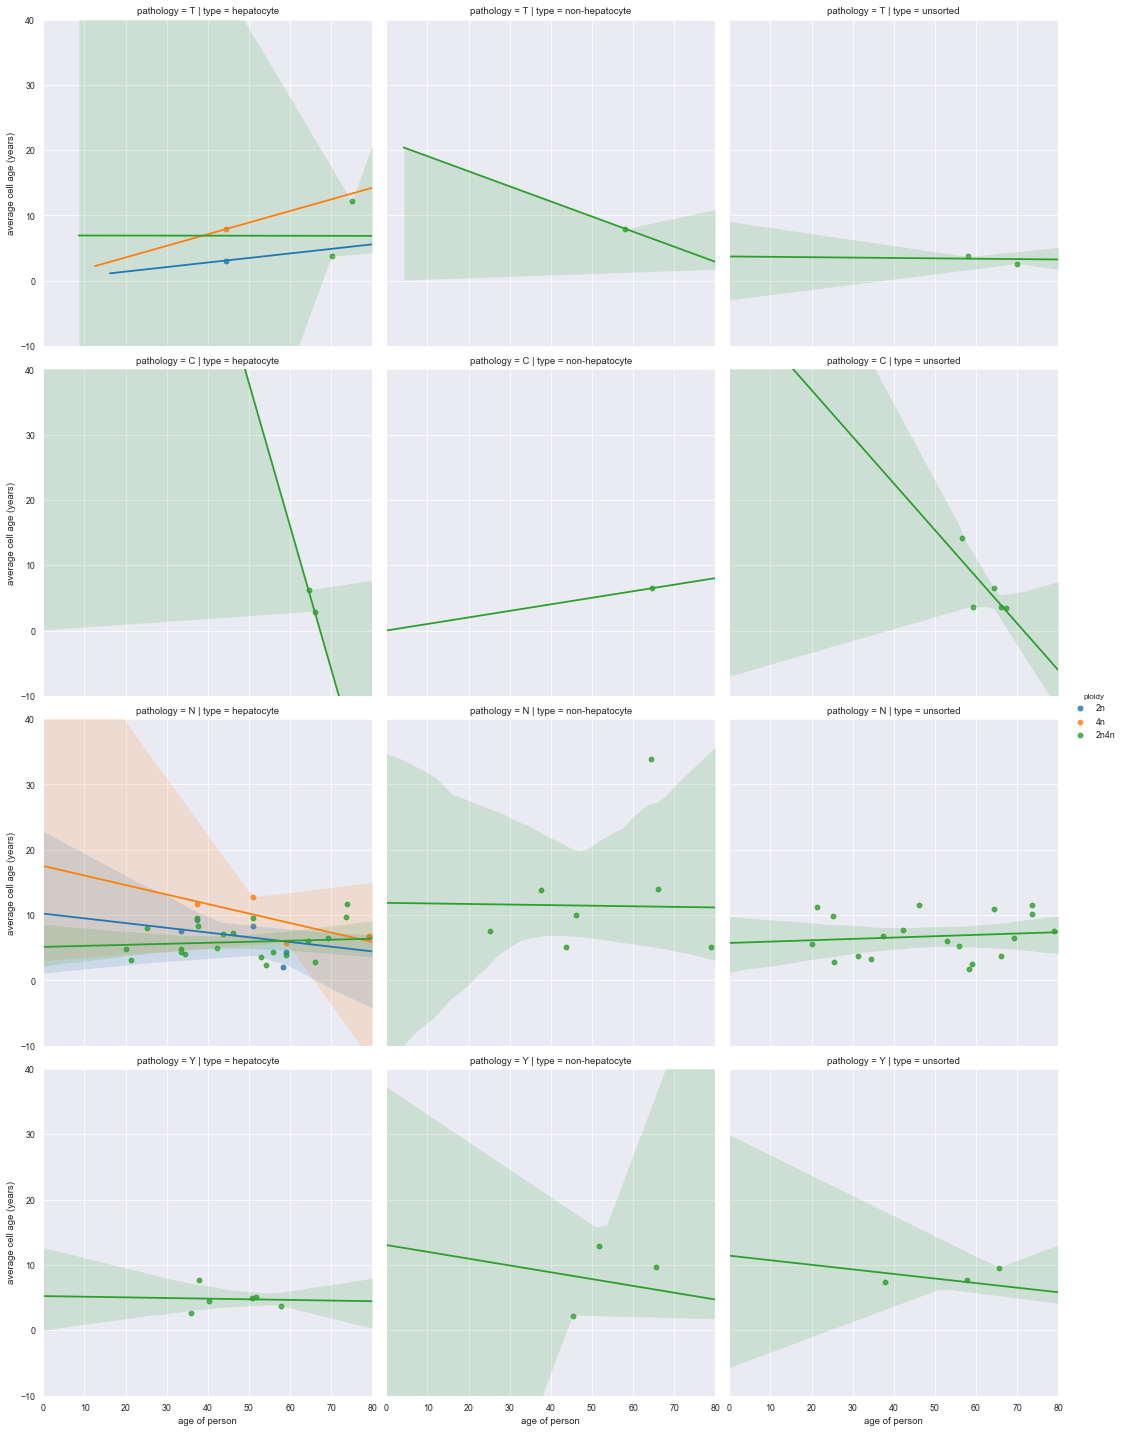

In [165]:
ax = sns.lmplot(x='subject_age', y='cell_age', col='type', data=plot_data,
               col_order=['hepatocyte', 'non-hepatocyte', 'unsorted'], hue='ploidy',
               row='pathology')
ax.set_axis_labels(x_var='age of person', y_var='average cell age (years)')
ax.set(xlim=(0, 80), ylim=(-10, 40))
# plt.savefig('../../results/plots/individual_rate_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

No significant correlation in the above data:

In [166]:
plot_data.groupby('type').apply(lambda g: pd.Series({key: value for key, value in zip(['r', 'p'],
    sp.stats.pearsonr(g['subject_age'], g['cell_age']))}))

,r,p
type,,
hepatocyte,-0.019589,0.897188
non-hepatocyte,-0.196194,0.483432
unsorted,-0.091273,0.625319


In [167]:
plot_data.groupby('type').apply(lambda g: smf.ols('cell_age ~ subject_age', data=g).fit().params)

,Intercept,subject_age
type,,
hepatocyte,6.233823,-0.003238
non-hepatocyte,14.171376,-0.087677
unsorted,7.305810,-0.016657


# Export

In [168]:
exp_data.to_excel('../../../results/200310_cell_age.xlsx')

In [169]:
exp_data.query('rate_is_not_outlier and (type == "hepatocyte")').mean()

Dbirth                    1962.617754
Dcoll                     2015.393116
d14C                         0.050935
e14C                         0.006659
N_cells                     69.902174
subject_age                 52.775362
age                         52.775362
individual_rate_SSE          0.204427
individual_rate_newton       0.205681
rate_is_not_outlier          1.000000
cell_age                     6.062962
dtype: float64